In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
df = pd.read_csv('gold.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["Volume", "Open", "Oil Close", "CAD Close", "Low", "High"])
df

,Gold Close,TSX Close,Bar Close
Date,,,
2010-01-04,1117.699951,11866.900391,35.995537
2010-01-05,1118.099976,11888.099609,36.337681
2010-01-06,1135.900024,11944.500000,36.936466
2010-01-07,1133.099976,11887.500000,36.474537
2010-01-08,1138.199951,11953.799805,36.560101
...,...,...,...
2020-12-21,1879.199951,17500.900391,29.590000
2020-12-22,1866.599976,17552.500000,29.040001
2020-12-23,1874.699951,17593.599609,29.389999


In [4]:
df_input = df
df_output = df[["Bar Close"]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [6]:
x_train.shape

(1878, 3)

In [7]:
x_test.shape

(805, 3)

In [8]:
x_test

,Gold Close,TSX Close,Bar Close
Date,,,
2017-09-08,1346.000000,14985.299805,20.796661
2017-09-11,1331.000000,15040.299805,20.305853
2017-09-12,1328.000000,15143.400391,20.450211
2017-09-13,1323.400024,15126.799805,20.046015
2017-09-14,1324.699951,15172.700195,20.103760
...,...,...,...
2020-12-21,1879.199951,17500.900391,29.590000
2020-12-22,1866.599976,17552.500000,29.040001
2020-12-23,1874.699951,17593.599609,29.389999


In [9]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [10]:
length = 1
batch = 44
features = 3

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=1, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=1, batch_size=batch)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [12]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17408     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [14]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.00053)

model.compile(optimizer="adam", loss="mean_squared_error")


fit = model.fit_generator(train_generator, epochs = 1000, validation_data=test_generator,
                         shuffle=False, callbacks=[earlystop])

Epoch 1/1000
43/43 [==============================] - 3s 70ms/step - loss: 0.2230 - val_loss: 0.0600
Epoch 2/1000
43/43 [==============================] - 2s 45ms/step - loss: 0.0798 - val_loss: 0.0680
Epoch 3/1000
43/43 [==============================] - 2s 56ms/step - loss: 0.0975 - val_loss: 0.0353
Epoch 4/1000
43/43 [==============================] - 2s 50ms/step - loss: 0.0523 - val_loss: 0.0283
Epoch 5/1000
43/43 [==============================] - 2s 54ms/step - loss: 0.0354 - val_loss: 0.0203
Epoch 6/1000
43/43 [==============================] - 2s 50ms/step - loss: 0.0220 - val_loss: 0.0204
Epoch 7/1000
43/43 [==============================] - 2s 47ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 8/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0149 - val_loss: 0.0165
Epoch 9/1000
43/43 [==============================] - 3s 62ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 10/1000
43/43 [==============================] - 2s 43ms/step - loss: 0.0091 - val_lo

In [16]:
model.evaluate_generator(test_generator, verbose=0)

0.0004968530395815737

In [22]:
predictions = model.predict_generator(test_generator)

In [23]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

In [24]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks

,Real,Predicted
Date,,
2017-09-11,20.305853,21.046423
2017-09-12,20.450211,20.538908
2017-09-13,20.046015,20.672626
2017-09-14,20.103760,20.262386
2017-09-15,20.276985,20.319033
...,...,...
2020-12-21,29.590000,29.727850
2020-12-22,29.040001,29.548941
2020-12-23,29.389999,28.932455


<AxesSubplot:title={'center':'Actual Vs. Predicted Prices'}, xlabel='Date'>

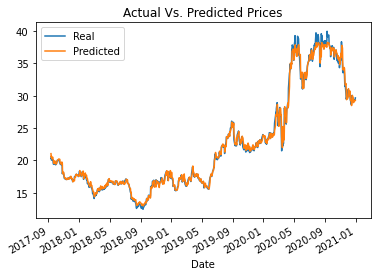

In [25]:
stocks.plot(title="Actual Vs. Predicted Prices")

In [26]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

-0.025810592803195878

In [27]:
model_json = model.to_json()
file_path = Path("bar_model_1.json")
with open(file_path, "w") as json_file:
    json_file.write(model_json)